# Machine Learning for Textual Data - The Bible and other religious texts
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Link to GitHub: https://github.com/Amglex/Machine-Learning-for-textual-data (master branch)


Elisa Fleissner       (14-350-608)

Marco Hassan          (14-731-921)

Lars Stauffenegger    (13-059-183)

Alexander Steeb       (17-614-611)

05.05.2019

--------------------------------------------------------------------------------------------

## Project plan and structure

In this project we analyse the bible text and other religious texts using machine learning for textual data. From this analysis we expect to see different relevant topics and contexts between the books of the bible and between the different religious texts.

This analysis is structured as follows: In a first step, a thorough analysis of the bible is done to understand different topics within the books and to see a development of the topics over time. We expect to see that certain topics where clearly more relevant in the old testament than in the new testament and vice versa. For the topic analysis in this paper, we will use the Latent Dirichlet Allocation (LDA) and the Word2Vec algorithm is used to understand the context of certain words. This allows to capture differences in the perception of one specific word in the old vs. new testament. We also apply a sentiment analysis to identify the sentiment evolvement over time.
In a second part we will then include other religious texts such as the Quran and others. We will perform an anlysis over five texts to find similarities and patterns. We use the same methods as in PART I, namely LDA, Word2vec and sentiment.

### PART I: The Bible ###
- Before starting with the analysis and data import, we need to first setup helper functions and import all relevant libraries used for this project. 
- Then we are importing the data and assigning the correct names of the books to the texts as well as the testament (old or new). 
- We then have to process the data to make it suitable for the machine learning algorithm. We achieve this by defining several formulas including preprocessing (inkl. tokenization), lemmatization and stopword removal.
- When the data is ready, the actual analysis can be performed

### PART II: 5 religious texts ###
- The imported functions and cleaning steps can be used from PART I, however, we need to import all texts and bring them to the same format (i.e. no separation between the different books of the bible)
- Cleaning of the data using the functions from PART I
- Analysis

## Setup

In [1]:
# Import functions
import json
import os
import shutil
import sys
import requests
import zipfile
import io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import word2vec

from pprint import pprint

In [2]:
# Option to display whole text and not only first few words
pd.set_option('display.max_colwidth', 1)

In [3]:
print(sys.executable)
print(sys.version)

/usr/local/Cellar/python/3.7.2_2/bin/python3.7
3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


Please find a list with all required python packages in the ```requirements.txt``` file in the github folder.

# PART I: The Bible

## Preparation
### TextBlob
It is important to install textblob correctly and to download the corpora. Source: https://textblob.readthedocs.io/en/dev/


```
pip install -U textblob
python -m textblob.download_corpora
```

### Helper functions

In [4]:
# Remove existing folder
# based on: https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty-with-python
def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
    else:
         # throw your exception to handle this special scenario
         print('Folder does not exist')

# Get one text string instead of separated text bits
def gen_full_text(texts):
    full_text = ''
    for text in texts:
        full_text += text
    return(full_text)

# Helper function to get the digits in one text
def get_num(text):
    return(int(''.join([n for n in text if n.isdigit()])))

# Stopwords
custom_stopwords = stopwords.words('english')
custom_stopwords.extend(["nephi","alma","mormoni","ether", "say", "let", "may", "give", 
                         "make", "come", "go", "take", "put", "an", "er", "see", "thing", "even", "'s",
                        "thou", "thy", "unto", "thee", "shall", "hath", "ye", "yea"])

## 1. Data import

In this section we will import the bible data. Particular caution has to be paid to the correct specification of the different books and the old/new testamnet as this is crucial for the following LDA analysis.

Data source: https://sites.google.com/site/ruwach/bibletext

In [5]:
remove_folder("data")

In [6]:
old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"

new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"
    
def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [7]:
# Create the paths and open the text files

path = "data"
df = pd.DataFrame()  

testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path, "r", encoding = "utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index = True)
                
df.columns = ["text", "testament", "book", "file", "path"]

In [8]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")

In [9]:
# Order the books
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))
books_order.columns = ["book", "order"]

# Merge the book information to the downloaded text
df = pd.merge(df,books_order, on ='book')

# Get the number out of the file name to sort the texts correctly
df['file'] = df['file'].apply(get_num)

df = df.sort_values(["order", "file"], ascending = [True, True])
df.reset_index(drop = True, inplace = True)

## 2. Data cleaning

In this section we will prepare the data to be analysed. We therefore need to apply different techniques to clean the data so that machine learning algorithms can analyse the data set. For a first inspection of the data, we will use a wordcloud and word count analysis.

The following steps are part of the preprocessing phase to make the text ready for the algorithms (https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34)

**Tools:** 
1. Preprocessor
    - Only keep latin characters
    - Remove roman numerals
    - Change all the text to lower case
    - Remove line breaks
    - We deliberately leave punctuation marks in it as they add additional meaning in conjunction with ngrams
2. Lemmatizer
    - Based on PoS tags
3. Remove Stop words
4. Wordcloud text processor

In [10]:
def preprocessor(t):
    '''
    Takes a str as an input and applies various preproccesing steps.
    Returns a str.
    '''
    # Regex to remove roman numerals / source: https://stackoverflow.com/questions/267399/how-do-you-match-only-valid-roman-numerals-with-a-regular-expression
    t = re.sub(r'(?=\b[MCDXLV]{1,6}\b)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})', ' ', t)
    t = t.lower() 
    t = t.replace('\\n', ' ') # Replace newline with space
    t = re.sub('[^a-zA-Z ?!.\'´`]',' ',t) # Delet all characters but those in the brackets
    return(t.strip())


# inspired by https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatizer(text):
    """
    Takes a str as an input and lemmatization based on PoS tagging 
    Returns a str
    """
    tagger = TextBlob.pos_tagger
    
    text = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in tagger.tag(text)] # Get words and corresponding tags
    lemmatized_list = [w.lemmatize(tag) for w, tag in words_and_tags] # Lemmatize each word based on its tag
    result = ' '.join(lemmatized_list)
    return(result)

def remove_stopwords(text):
    """
    Takes a str as an input and removes all stopwords based on a "custom_stopwords" list
    Returns a str
    """
    text = TextBlob(text)
    text = (token for token in text.tokens if token not in custom_stopwords)
    stopremoved = ' '.join(text)
    return(str(stopremoved))

def wordcloud_map(text_corp):
    """"
    Takes one column of a Pandas Dataframe with strings as an input
    Concatonates these strings and generates a wordcloud
    Returns the wordcloud 
    """
    full_text = ''
    for text in text_corp:
        full_text += text          
    wordcloud = WordCloud(max_font_size = 40,background_color = "white").generate(full_text)

    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

### Precprocessing demonstration

In [11]:
selected_book = 'Exodus'
selected_part = 20

test_text = df.loc[(df['book'] == selected_book) & (df['file'] == selected_part),['text']].to_string(header = False)
test_text = test_text[:250]

print('Original text \n' )
pprint(test_text)

test_text = preprocessor(test_text)
print('\n Preprocessed text \n')
pprint(test_text)

print('\n Lemmatized text \n')
test_text = lemmatizer(test_text)
pprint(test_text)

print('\n Final Text after removing of stopwords \n')
test_text = remove_stopwords(test_text)
pprint(test_text)

Original text 

('69  1 And God said all these words:\\n2 I am the Lord your God who took you '
 'out of the land of Egypt, out of the prison-house.\\n3 You are to have no '
 'other gods but me.\\n4 You are not to make an image or picture of anything '
 'in heaven or on the earth or')

 Preprocessed text 

('and god said all these words    i am the lord your god who took you out of '
 'the land of egypt  out of the prison house.   you are to have no other gods '
 'but me.   you are not to make an image or picture of anything in heaven or '
 'on the earth or')

 Lemmatized text 

('and god say all these word i be the lord your god who take you out of the '
 'land of egypt out of the prison house . you be to have no other god but me . '
 'you be not to make an image or picture of anything in heaven or on the earth '
 'or')

 Final Text after removing of stopwords 

('god word lord god land egypt prison house . god . image picture anything '
 'heaven earth')


### Apply text cleaning to bible text

In [12]:
# Applying the preprocessor and lemmatizer to the text
df['clean'] = df['text']
df['clean'] = df['clean'].apply(preprocessor)
df['clean'] = df['clean'].apply(lemmatizer)

# Applying the stopword removal to the text
df['clean_rm'] = df['clean'].apply(remove_stopwords)

## 3. Data inspection
In this section we will conduct some simple analysis of the processed data to better understand the most frequent words. We will use a wordcloud ...

### Wordcloud

The wordcloud is used to display the frequency of the words by size. This is a suitable tool for to get a first glimpse of the texts to be analysed.

We conduct this analysis for
- the entire bible
- the old testament
- the new testament

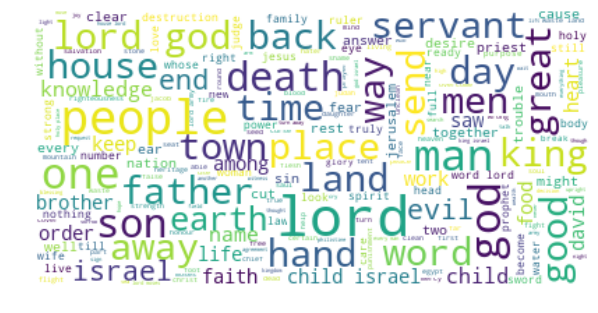

Old Testament


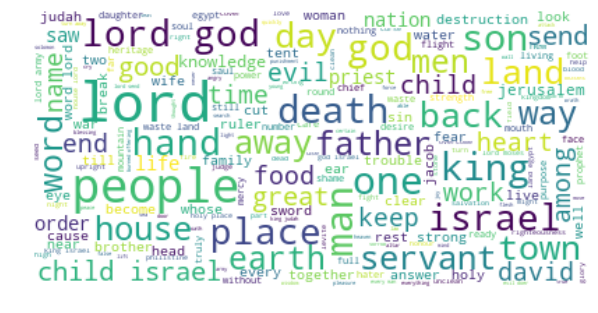

New Testament


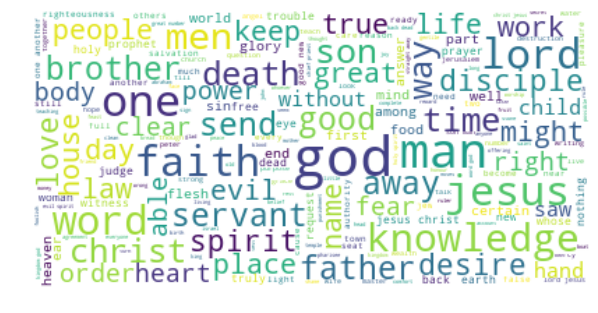

In [13]:
# Entire bible
wordcloud_map(df['clean_rm'])

# Old testament
i = 0
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean_rm']
wordcloud_map(data)

# New testament
i = 1
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean_rm']
wordcloud_map(data)

### Term frequency
In this analysis we will compare the word frequency of the entire bible to the old and new testament.

In [14]:
# We define a function for the word count and plotting
def word_count(text,title):
    full_text = ''
    for words in text:
            full_text += words

    blob = TextBlob(full_text)

    word_freq = pd.DataFrame(blob.word_counts.items(), columns=['Word', 'Frequency'])

    word_freq = word_freq.sort_values('Frequency',ascending=False)
    word_freq.reset_index(drop = True, inplace = True)
    word_freq.set_index('Word', inplace=True)

    word_freq['Frequency'] = word_freq['Frequency'] / sum(word_freq['Frequency'])

    word_freq[:10].plot(kind='barh',figsize=(12,4),title=title,legend=False,xlim=(0.005,0.035))

Word frequency as a proportion of the respective text


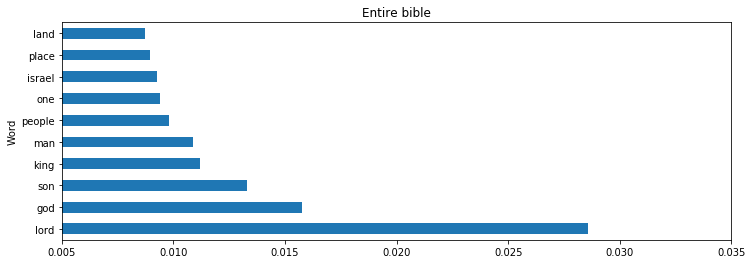

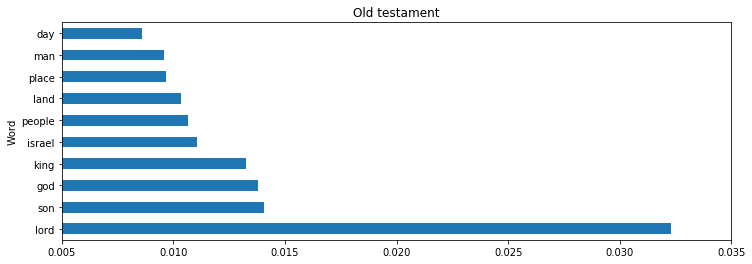

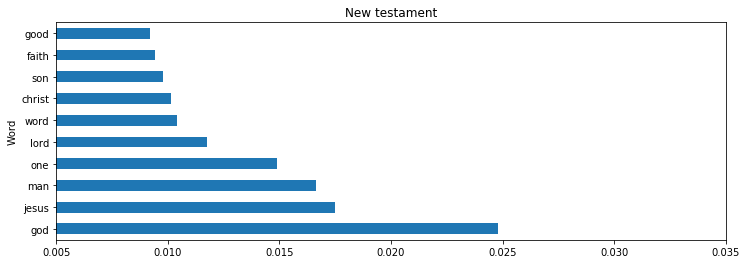

In [15]:
# Calling the function and plotting the results 
print("Word frequency as a proportion of the respective text")
text = df["clean_rm"]
word_count(text, "Entire bible")

text = df.loc[df.testament == "Old Testament", "clean_rm"]
word_count(text, "Old testament")

text = df.loc[df.testament == "New Testament", "clean_rm"]
word_count(text, "New testament")

### Noun phrase extraction
Additionally we can make use of the part of speech tagging to identify the most important noun phrases in the two parts of the bible.

Note that this is computationaly intensive and therfore we only use the first 25% of each text. Of course this parameter can be adjusted to get a more precise picture across the whole text.

In [16]:
# We define a function for the word count and plotting
def noun_phrase_count(text,book='text',part = 0.1):
    """
    Extracts and displays the most frequent noun phrases in a given text
    Inputs:
        text : df with type str
        book : Titel of the text analysed
        part : proportion of the given text to use -> Start small and see how fast it goes
    """
    
    title="Most frequent noun phrases in the first {}% of the {}".format(part*100,book)
    
    full_text = ''
    for words in text:
            full_text += words
    
    len_text = len(full_text)
    part = round(part * len_text)
    
    blob = TextBlob(full_text[:part])

    word_freq = pd.DataFrame(blob.np_counts.items(), columns=['Word', 'Frequency'])

    word_freq = word_freq.sort_values('Frequency',ascending=False)
    word_freq.reset_index(drop = True, inplace = True)
    word_freq.set_index('Word', inplace=True)

    word_freq['Frequency'] = word_freq['Frequency'] / sum(word_freq['Frequency'])

    word_freq[:10].plot(kind='barh',figsize=(12,4),title=title,legend=False)

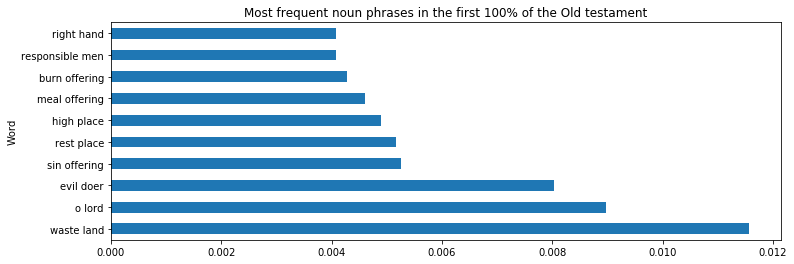

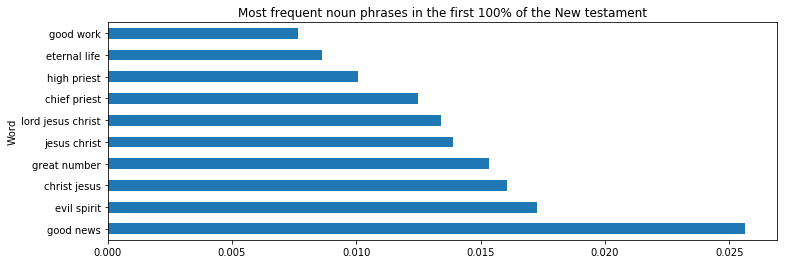

In [17]:
text = df.loc[df.testament == "Old Testament", "clean"]
noun_phrase_count(text,part=1,book='Old testament')

text = df.loc[df.testament == "New Testament", "clean"]
noun_phrase_count(text,part=1,book='New testament')

We will upload a picture of this plot for 100% of the data on the github of this project

## 4. Model 1 - LDA

### Description of the model
Latent Dirichlet Allocation (LDA) is a method to identify topics within a text corpus. This model has been developed by [Blei, Ng and Jordan (2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) and is based on a three-level hierarchical Bayesian model and the Dirichlet distribution. 
We will use this method for a preliminary analysis on our bible texts to see whether the topics discussed in the books have been changing over time. We expect to see that over the time (over the evolvement of the different books), the topics have changed significantly. An interesting change will probably also be observed for the beginning of the new testament.
We got inspiration for this code from Knoepfl, Rieger & Sommer (2018).

### Estimation 1: Topic identification and wordcloud representation
In this step, we use a count vectorizer and a LDA model to identify the different topics and output the most important words for each topic.

In [18]:
# Choose the number of topics that should be identified
n_components = 4

In [19]:
# Get the text
text = df['clean_rm']

# Vectorize the text
count = CountVectorizer(
            min_df = 3, # A word has to appear at least x times to be included
            max_df = 0.90, # Top (1-x)% most frequent words are removed since they propably are of limited value
            ngram_range = (1,4) # What kind of ngrams to include. We include everything from 1-grams to 4-grams
            )

txt_count = count.fit_transform(text)
txt_count

<1136x27444 sparse matrix of type '<class 'numpy.int64'>'
	with 282805 stored elements in Compressed Sparse Row format>

In [21]:
# Fit LDA model
lda = LatentDirichletAllocation(
    n_components = n_components, # How many topics are there -> hyper parameter
    random_state = 123, # random seed for reproducability
    learning_method = 'batch', # Evaluate all documents at once as opposed to the online method
    max_iter = 250, # After how many evaluation steps should the algo stop. Choose fewer for faster processing
    verbose = False, # Show each step
    n_jobs = 1,# Normally this parameter controlls how many parallel processes are used. However, on our MacBook it didn't work
    evaluate_every = 1
)

X_topics = lda.fit_transform(txt_count)
lda.components_.shape

(4, 27444)

In [22]:
# Print most important words of every topic
print("The most important words of our four topics are:")

n_top_words = 10
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print()
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))    

The most important words of our four topics are:

Topic 1:
offering lord moses holy priest one house day israel tent

Topic 2:
man god one jesus word get good lord evil father

Topic 3:
lord god land people place like word day keep send

Topic 4:
king son lord israel child david men town people land


### Estimation 2: Evolvement over time
In this step we will plot the different topics identified in step 1 over the development of the bible (the books).

In [23]:
X_topics = pd.DataFrame(X_topics)

X_topics['order'] = df['order']

X_topics_mean = X_topics.groupby(df['book']).mean()

X_topics_mean = X_topics_mean.sort_values('order', )
df.reset_index(drop=True, inplace=True)

X_topics_mean =X_topics_mean.iloc[:,0:n_components]

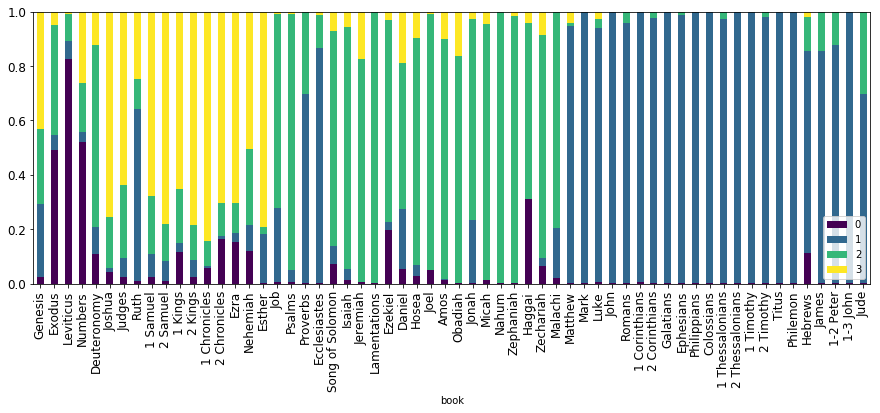

In [24]:
X_topics_mean.plot(kind = 'bar',
                   stacked = True,
                   rot = 'vertical',
                   ylim = (0,1),
                   figsize = (15,5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = 'viridis'
                  )

We can see very nicely that the algorithm detects phases in the bible which are dominated by specific topics. This is especially noteworthy since the order of the books is not known to the algorithm. Additionally, one has to note that the bible is believed to be written by at least 80 person indicating that the writing style alone also can't be the reason for the patterns.

One direct application of this topic modelling would be to identify the books of the old testament which are most similar to the new testament. For example, the Book of Proverbs or the Ecclesiastes seem to share much with the new testament. A person with a better knowledge of the bible than us could undoubtedly draw many interesting conclusions from this plot.

## 5. Model 2 - Word2vec

As a second model we would like to present the Word2vec model, which allows for contextual analysis. The model has been introduced by [Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). The word2vec method allows to reconstruct linguistic features of the corpus analysed and embedds the words in their context using a shallow two-layer network. This method allows to evaluate the associations to a certain word and thus allows to capture the sentiment of the text. Inspiration for this part has been obtained [here](https://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb). 

Using this method, we can detect different word associations within the different parts of the bible. We expect for example, that the word *"god"* could be embedded differently in the old than in the new testament.

### Model estimation

In [25]:
# Preparation
remove_folder("model")
os.mkdir("model")

In [26]:
# Open all three text files (full text, old and new testament)

with open("model/text_full.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[:,'clean']))
    
with open("model/text_old.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[df['testament'] == testaments[0],'clean']))

with open("model/text_new.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[df['testament'] == testaments[1],'clean']))

In [27]:
# Write a function to estimate the word2vec model
def estimate_word2vec(file):
    print('Start')
    word2vec.word2phrase(train = file, 
                        output = "model/text-phrases", 
                        min_count = 1,
                        verbose = False)
    word2vec.word2vec("model/text-phrases", "model/text.bin", 
                        size = 100, # Size of the underlying NN. Larger can increase accuracy but also requires a lot of data
                        min_count = 2,
                        # sample = 1e-5, # Downsample high frequenzy words
                        verbose = False)
    print('Finished')
    return(word2vec.load('model/text.bin'))

In [28]:
# Estimate all three models and print the progress

print("Fit full model")
model_full = estimate_word2vec('model/text_full.txt')

print('\n')
print("Fit old testament model")
model_old = estimate_word2vec('model/text_old.txt')

print('\n')
print("Fit new testament model")
model_new = estimate_word2vec('model/text_new.txt')

Fit full model
Start
Finished


Fit old testament model
Start
Finished


Fit new testament model
Start
Finished


### Similarity analysis

In [29]:
def plot_word2vec(model,text_title,token):
    # Set a token for which similar words should be found
    token = token
    title = "{} - Related words to -> {}".format(text_title,token)
    
    # For entire bible text
    indexes, metrics = model.similar(token)
    model_df = model.generate_response(indexes, metrics).tolist()

    plot_df = pd.DataFrame(model_df)
    plot_df.set_index(plot_df[0], inplace=True)
    plot_df.plot(kind='barh',figsize=(10,4), fontsize=12, title=title,legend=False,xlim=(0.5,1))    
    plt.ylabel('Proximity')

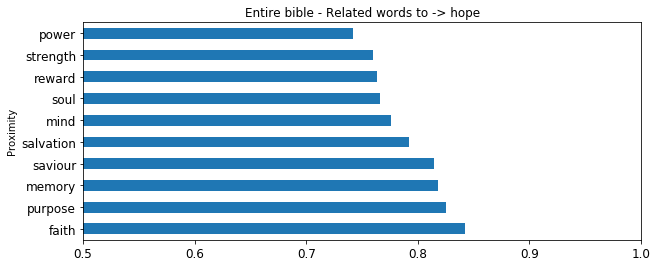

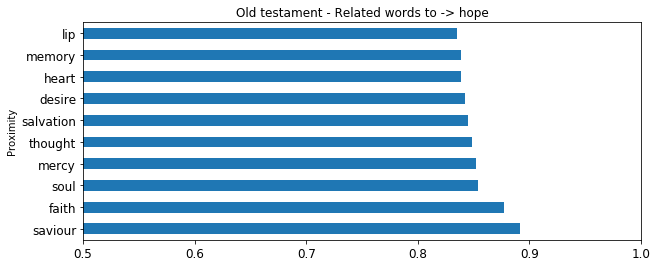

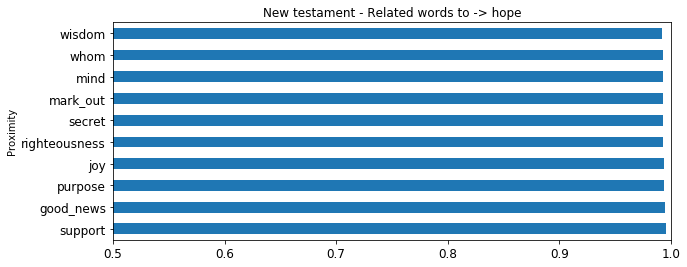

In [30]:
# Entire bible
token = 'hope'
plot_word2vec(model_full, text_title = 'Entire bible', token = token)

plot_word2vec(model_old, text_title = 'Old testament', token = token)

plot_word2vec(model_new, text_title = 'New testament', token = token)

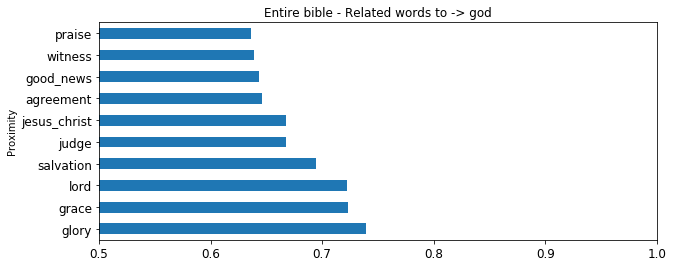

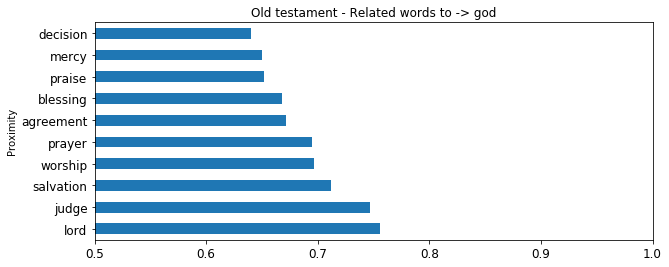

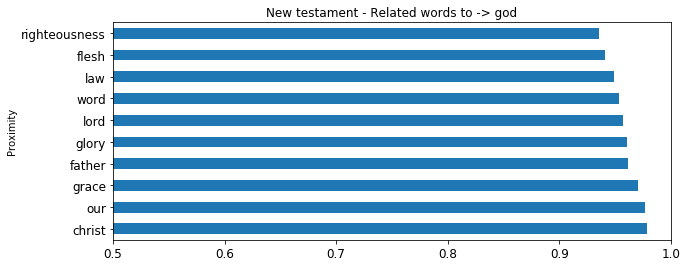

In [31]:
# Entire bible
token = 'god'
plot_word2vec(model_full, text_title = 'Entire bible', token = token)

plot_word2vec(model_old, text_title = 'Old testament', token = token)

plot_word2vec(model_new, text_title = 'New testament', token = token)

We can see that in general the overall similarity increases for smaller texts. Also note that word2vec should normally be used with far more data. Therefore, in this case the interpretability is limited. This can also be seen in the results above. The results for the entire text make the most sense.

Interestingly, word2vec automatically detects ngrams like for example jesus_christ and good_news.

### Analogies
One of the main features of word2vec is that it allows us to construct analogies like the classical king - man + women = queen analogy.

With a more extensive text corpus this feature can be highly useful since it allows us to identify complex relations between the words in the analyzed text.

In [32]:
indexes, metrics = model_full.analogy(pos = ['king', 'woman'], neg = ['man'])
model_full.generate_response(indexes, metrics).tolist()

[('captain', 0.30667434563709217),
 ('joab', 0.30380299214137757),
 ('david', 0.2966341002452381),
 ('responsible_men', 0.2951263001138681),
 ('judah', 0.2905816134861074),
 ('jehoshaphat', 0.28742930211613893),
 ('saul', 0.28220020501853765),
 ('chief', 0.2816192317821867),
 ('sent', 0.2813039991869736),
 ('benjamin', 0.277178693064046)]

## 6. Sentiment
In this section we analyse the sentiments of each book of the bible. For simplicity, we use an already existing model to quickly get a feeling about which parts of the bible are more positive and which are more negative.

In [33]:
# Calculate the sentiment and group in data frame
df['sentiment'] = df['clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sentiment = df[['sentiment','order']].groupby(df['book']).mean()
sentiment = sentiment.sort_values('order', )
#df.reset_index(drop=True, inplace=True)
sentiment = sentiment.iloc[:,[0]]

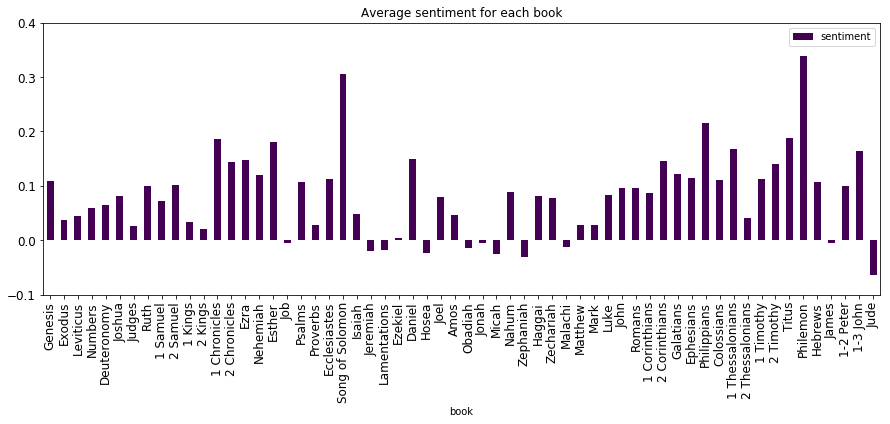

In [34]:
# Plot the sentiment
sentiment.plot(kind = 'bar',
                   rot = 'vertical',
                   ylim = (-0.1,0.4),
                   title = 'Average sentiment for each book',
                   figsize = (15, 5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = "viridis"
                  )

Interestingly, the only book of the bible with a relatively large negative sentiment is the last book Jude. Also note that as expected the new testament seems to be on average more positive than the old testament.

# PART II: Comparison of religious texts
In this second part of our project we focus not only on the bible but on five different religious books. We obtained the books from [Kaggle](https://www.kaggle.com/tentotheminus9/religious-and-philosophical-texts). The following texts are analysed
- The King James Bible
- The Quran
- The Book Of Mormon
- The Gospel of Buddha
- Meditations, by Marcus Aurelius

## 1. Import all texts

In [35]:
# Prepare the paths for importing
path = "texts"
df_books = pd.DataFrame() 

books = os.listdir(path)
books

['Meditations.txt', 'Mormon.txt', 'Bible.txt', 'Koran.txt', 'Buddha.txt']

In [36]:
# Prepare the paths to each file
book_list = list()

for book in books:
    book_path = os.path.join(path,book)
    print(book_path)
    with open(book_path, "r", encoding = "utf-8") as infile:
        raw_text = infile.read()
        book_list.append(raw_text)
        #df_books = df_books.append([[book, raw_text, book_path]], ignore_index=True)

texts/Meditations.txt
texts/Mormon.txt
texts/Bible.txt
texts/Koran.txt
texts/Buddha.txt


In [37]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path, books[0])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        meditations = TextBlob(raw_text)        

start = meditations.find("MARCUS AURELIUS ANTONINUS was born on April 26")
end = meditations.find("THIS being neither a critical edition of the text")
meditations = meditations[start:end]

meditations_clean = meditations.raw
meditations_clean = preprocessor(meditations_clean)
meditations_clean = lemmatizer(meditations_clean)
meditations_clean_rm = remove_stopwords(meditations_clean)

texts/Meditations.txt


In [38]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[1])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        mormon = TextBlob(raw_text)        

start = mormon.find("THE BOOK OF MORMON")
end = mormon.find("End of the Project Gutenberg EBook of The Book Of Mormon, by Anonymous")
mormon = mormon[start:end]

mormon_clean = mormon.raw
mormon_clean = preprocessor(mormon_clean)
mormon_clean = lemmatizer(mormon_clean)
mormon_clean_rm = remove_stopwords(mormon_clean)

texts/Mormon.txt


In [39]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[3])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        koran = TextBlob(raw_text)        

start = koran.find("SURA1 XCVI.-THICK BLOOD, OR CLOTS OF BLOOD [I.]")
end = koran.find("End of The Project Gutenberg Etext of The Koran")
koran = koran[start:end]

koran_clean = koran.raw
koran_clean = preprocessor(koran_clean)
koran_clean = lemmatizer(koran_clean)
koran_clean_rm = remove_stopwords(koran_clean)

texts/Koran.txt


In [40]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[4])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        buddha = TextBlob(raw_text)        

start = buddha.find("Rejoice at the glad tidings!")
end = buddha.find("TABLE OF REFERENCE.")
buddha = buddha[start:end]

buddha_clean = buddha.raw
buddha_clean = preprocessor(buddha_clean)
buddha_clean = lemmatizer(buddha_clean)
buddha_clean_rm = remove_stopwords(buddha_clean)

texts/Buddha.txt


In [41]:
# We use the bible text from PART I
bible_clean = gen_full_text(df['clean'])
bible_clean_rm = gen_full_text(df['clean_rm'])

In [42]:
all_texts = pd.DataFrame([['Bible', bible_clean_rm, bible_clean],
                    ['Meditations', meditations_clean_rm, meditations_clean],
                    ['Mormon', mormon_clean_rm, mormon_clean],
                    ['Koran', koran_clean_rm, koran_clean],
                    ['Buddha', buddha_clean_rm, buddha_clean]])

all_texts.columns = ['book', 'clean_rm', 'clean']

### Term frequency
In this analysis we will compare the word frequency of the entire bible to the old and new testament.

Word frequency as a proportion of the respective text


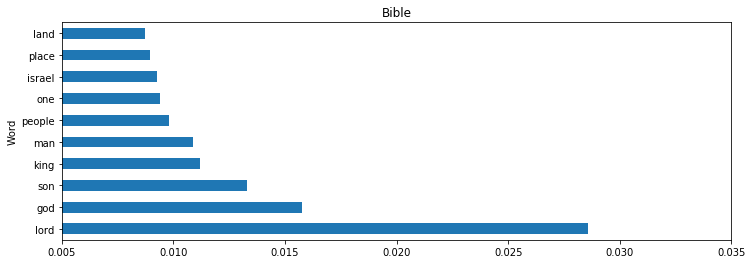

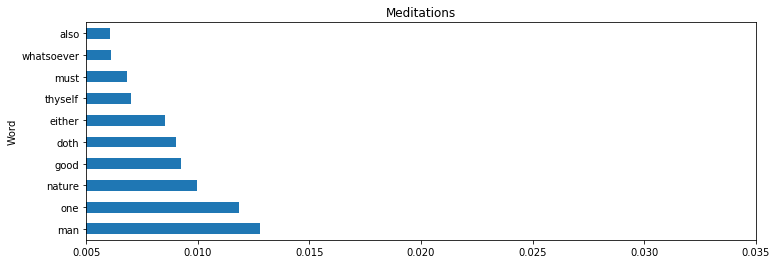

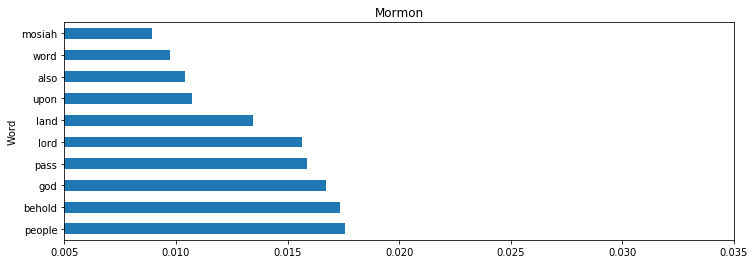

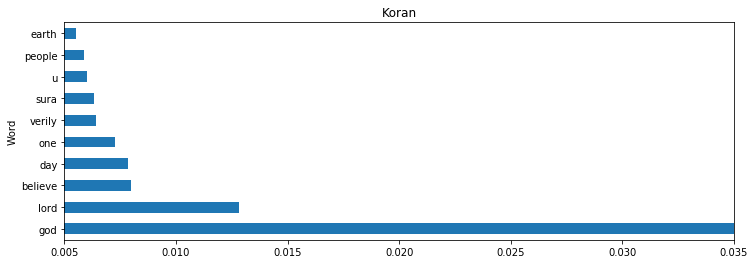

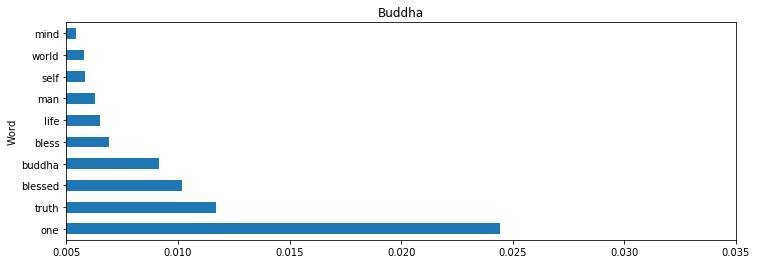

In [43]:
# Calling the function and plotting the results 
print("Word frequency as a proportion of the respective text")

word_count(bible_clean_rm, 'Bible')

word_count(meditations_clean_rm, 'Meditations')

word_count(mormon_clean_rm, 'Mormon')

word_count(koran_clean_rm, 'Koran')

word_count(buddha_clean_rm, 'Buddha')

### Noun phrase extraction
Additionally we can make use of the part of speech tagging to identify the most important noun phrases in the two parts of the bible.

Note that this is again computationaly intensive. Of course this parameter can be adjusted to get a more precise picture across the whole text. 

Done
Done
Done
Done


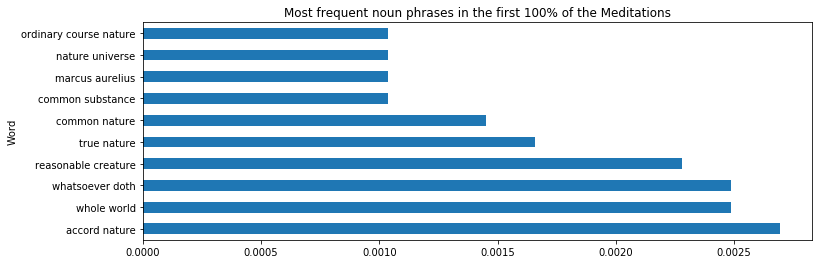

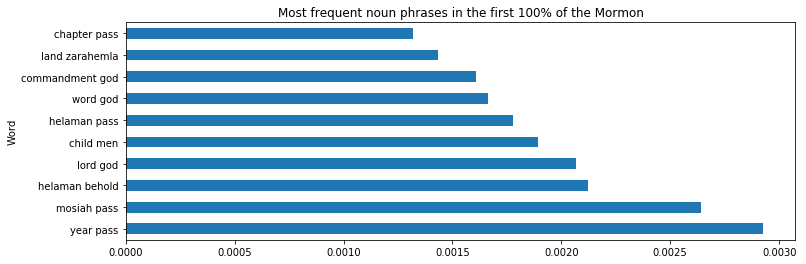

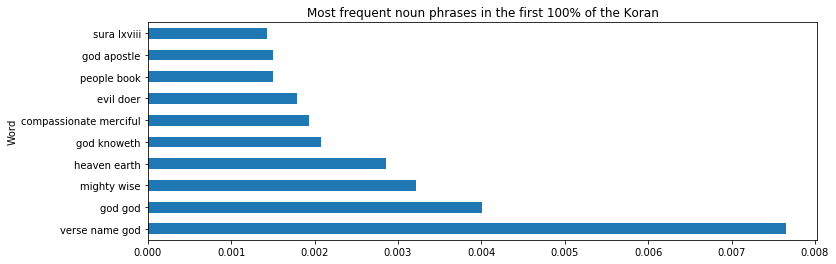

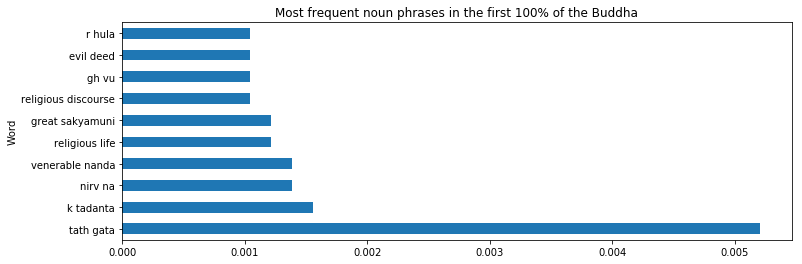

In [46]:
part = 1

#noun_phrase_count(bible_clean_rm, part=part, book='Bible')

noun_phrase_count(meditations_clean_rm, part=part, book='Meditations')
print('Done')
noun_phrase_count(mormon_clean_rm, part=part, book='Mormon')
print('Done')
noun_phrase_count(koran_clean_rm, part=part, book='Koran')
print('Done')
noun_phrase_count(buddha_clean_rm, part=part, book='Buddha')
print('Done')

# 2. LDA analysis

In [47]:
# Choose the number of topics that should be identified
n_components = 5

In [52]:
text = [text for text in all_texts['clean_rm']]

count = CountVectorizer(
            min_df = 2, 
            max_df = 0.95,
            
            # Note that we only include 2grams and 3grams in this case since this yields the best results        
            ngram_range = (2,3) 
            )

txt_count = count.fit_transform(text)
txt_count

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components = n_components, 
    random_state = 123, 
    learning_method = 'batch',
    max_iter = 100,
    verbose = False,
    evaluate_every= 1)

X_topics = lda.fit_transform(txt_count)

lda.components_.shape

# Print most important words of every topic
print("The most important words of our four topics are:")

n_top_words = 10
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print()
    print("Topic %d:" % (topic_idx + 1))
    print(" - ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))    


The most important words of our four topics are:

Topic 1:
lord god - child israel - word lord - waste land - lord army - lord lord - king israel - house lord - god israel - holy place

Topic 2:
bless one - holy one - pass away - one address - truth truth - good deed - path lead - old age - one holy - one brother

Topic 3:
heaven earth - god god - lord god - gather together - name god - fear god - child men - bring forth - house israel - compassionate merciful

Topic 4:
accord nature - true nature - common good - whole world - must needs - must need - shalt find - call mind - nature man - well pleased

Topic 5:
one hundred - earth water - look back - long live - life truly - among good - good eye - without doubt - life get - side lord


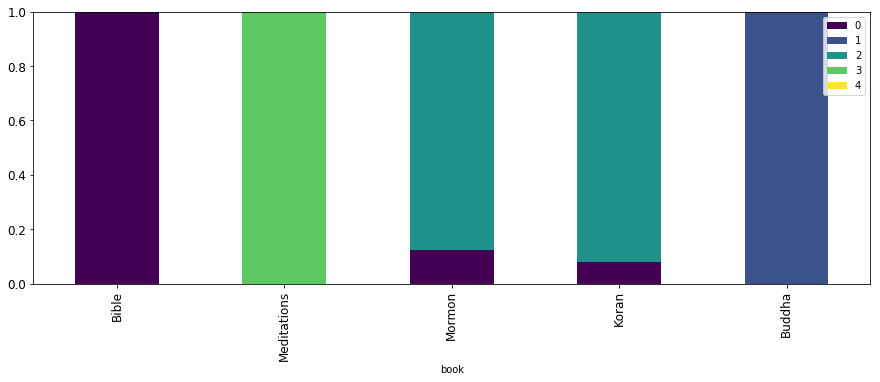

In [53]:
X_topics = pd.DataFrame(X_topics)
X_topics.index = all_texts['book']

X_topics.plot(kind = 'bar',
                   stacked = True,
                   rot = 'vertical',
                   ylim = (0,1),
                   figsize = (15, 5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = "viridis"
                  )

It is fascinating to see that each religious text mostly covers one topic. However, we can also see that although there is one topic that appears nowhere the book of Mormon and the Koran share the same topic and both also include at least a part of the bible topic. Presumably, this can be explained by looking at the above term frequencies. All three of these books have god as an essential topic in contrast to the other two.

# 3. Word2vec

In [54]:
# Preparation
remove_folder("model_new")
os.mkdir("model_new")

# Open all three text files (full text, old and new testament)
with open("model_new/meditations_clean.txt", "w") as text_file:
    text_file.write(meditations_clean)
    
with open("model_new/mormon_clean.txt", "w") as text_file:
    text_file.write(mormon_clean)

with open("model_new/bible_clean.txt", "w") as text_file:
    text_file.write(bible_clean)

with open("model_new/koran_clean.txt", "w") as text_file:
    text_file.write(koran_clean)
    
with open("model_new/buddha_clean.txt", "w") as text_file:
    text_file.write(buddha_clean)

In [55]:
model_Meditations = estimate_word2vec('model_new/meditations_clean.txt')
model_Mormon = estimate_word2vec('model_new/mormon_clean.txt')
model_Bible = estimate_word2vec('model_new/bible_clean.txt')
model_Koran = estimate_word2vec('model_new/koran_clean.txt')
model_Buddha = estimate_word2vec('model_new/buddha_clean.txt')

Start
Finished
Start
Finished
Start
Finished
Start
Finished
Start
Finished


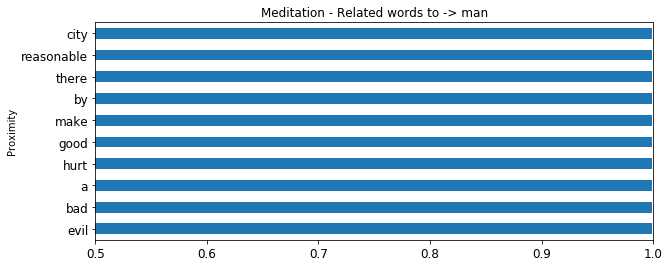

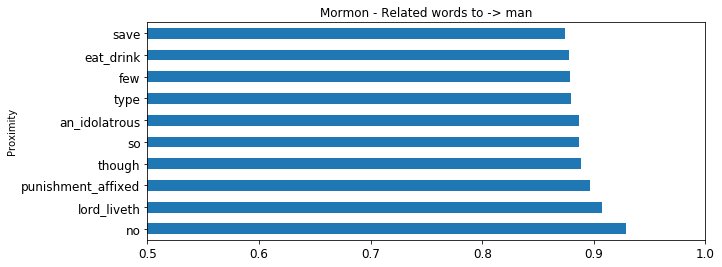

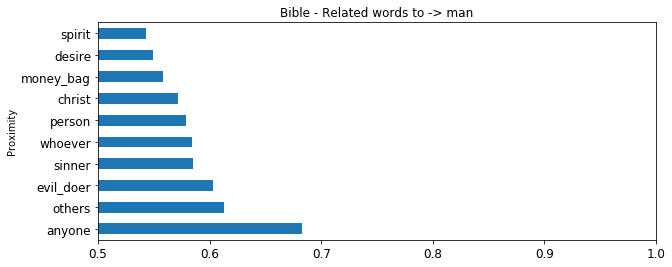

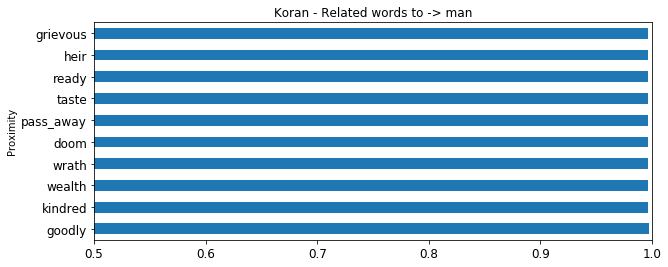

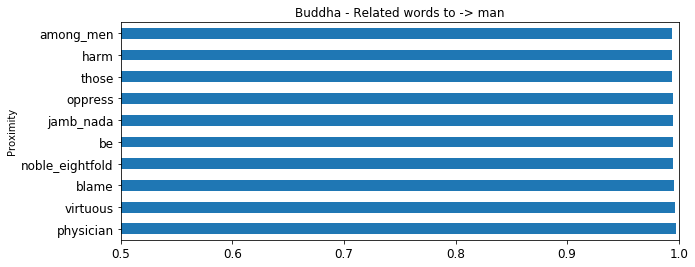

In [56]:
token = 'man'

plot_word2vec(model_Meditations, text_title = 'Meditation', token = token)

plot_word2vec(model_Mormon, text_title = 'Mormon', token = token)

plot_word2vec(model_Bible, text_title = 'Bible', token = token)

plot_word2vec(model_Koran, text_title = 'Koran', token = token)

plot_word2vec(model_Buddha, text_title = 'Buddha', token = token)

# 4. Sentiment

In [57]:
all_texts['sentiment'] = all_texts['clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sentiment = all_texts[['book','sentiment']].groupby(['book']).mean()

<Figure size 432x288 with 0 Axes>

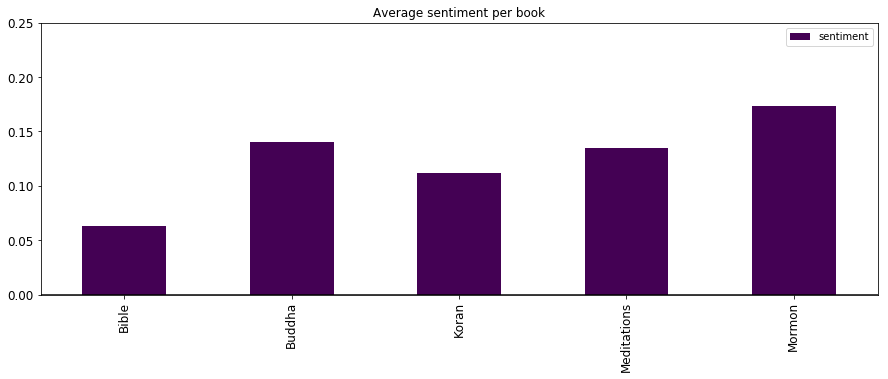

In [58]:
plt.figure();

ax = sentiment.plot(kind = 'bar',
                   rot = 'vertical',
                   title = "Average sentiment per book",
                   ylim = (0,0.25),
                   figsize = (15, 5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = "viridis"
                  )
ax.set_xlabel("")
plt.axhline(0, color = 'k')

## Subjectivity

Additionally, we can also calculate the subjectivity of each text to see if there are major differences.
The scale is as follows: 

0.0 = objective

+1.0 = subjective

In [62]:
all_texts['subjectivity'] = all_texts['clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
subjectivity = all_texts[['book','subjectivity']].groupby(['book']).mean()

<Figure size 432x288 with 0 Axes>

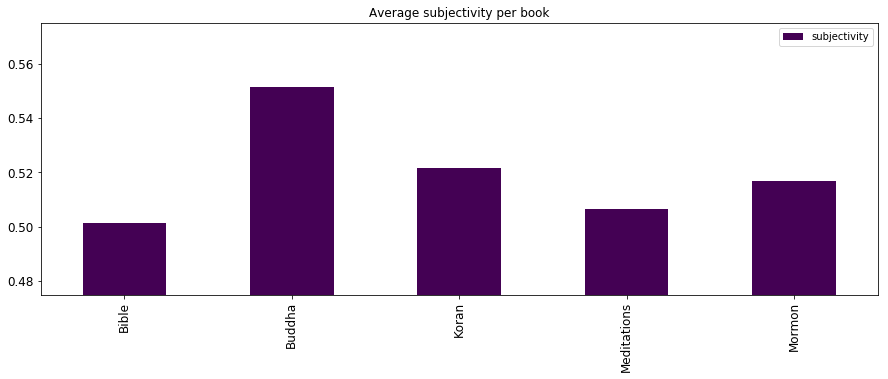

In [67]:
plt.figure();

ax = subjectivity.plot(kind = 'bar',
                   rot = 'vertical',
                   title = "Average subjectivity per book",
                   ylim = (0.475,0.575),
                   figsize = (15, 5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = "viridis"
                  )
ax.set_xlabel("")
plt.axhline(0, color = 'k')

# Final remarks
This project is using religious texts - and in particular the bible - to apply machine learning techniques that allow text analysis. We used two models for the text analysis: The LDA, the Word2vec and sentiment models. We could identify different topics within the bible and between the religious texts and see their development over time. We also used word embedding techniques to analyse the associations to certain words in the different texts. One major challenge in this project is the use of stopwords, as the texts are written in a more antique language, and some stopwords are not included in the common stopwords selection. There are many other text analysis tools, especially the recently introduced LDA2vecmodel by [Chris Moody (2016)](https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/#topic=38&lambda=1&term=).